### imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.precision", 2)
pd.set_option('display.max_columns', None)

plt.style.use('ggplot')

### Functions

In [2]:
def accuracy(data):
    correct_answers_mask = data["currentAnswer"] == data["vote"]
    n_answers = correct_answers_mask.count()
    n_answers_success = correct_answers_mask.sum()

    if n_answers == 0:
        accuracy = None
    elif n_answers_success == 0:
        accuracy = 0
    else:
        accuracy = n_answers_success/n_answers * 100

    return pd.Series({"n_correct": n_answers_success, "n_pred": n_answers, "accuracy": accuracy})


def acc_per_tool(group, col: str, conf: float):
    return group.apply(lambda x: accuracy(x[x[col] == conf]))


def gen_stats(df, tools_group, group, col: str):
    stats = {f"{col}_{prob}" : acc_per_tool(group, col, prob) for prob in sorted(df[col].unique())}
    stats["total"] = tools_group.apply(accuracy)
    return pd.concat(stats.values(), axis=1, keys=stats.keys())

### load data

In [3]:
dataset = pd.read_csv("../dataset.csv")
str_cols = ("id", "currentAnswer", "title", "request_id", "prompt", "tool", "nonce", "vote")
for col in str_cols:
    dataset[col] = dataset[col].astype("string")
dataset.head()

,id,currentAnswer,title,request_id,request_block,prompt,tool,nonce,deliver_block,p_yes,p_no,confidence,info_utility,vote,win_probability
0,0x0094fa304017d5c2b355790e2976f769ea600492,No,Will the Hisense U8K be considered a top-tier ...,1429730407779530824523722231071959771311408049...,29544655,"With the given question ""Will the Hisense U8K ...",prediction-online,c6366b3f-eff5-4533-8dd9-d653b281b29d,29577379,0.60,0.40,0.8,0.5,Yes,0.60
1,0x0094fa304017d5c2b355790e2976f769ea600492,No,Will the Hisense U8K be considered a top-tier ...,1695055931594747475916883029584567955775422500...,29545478,"With the given question ""Will the Hisense U8K ...",prediction-online,1eed33a5-a3f0-41c4-beae-23e9022ffe22,29576660,0.60,0.40,0.8,0.7,Yes,0.60
2,0x0094fa304017d5c2b355790e2976f769ea600492,No,Will the Hisense U8K be considered a top-tier ...,5972945302788386668720465960403202339977906500...,29546230,"With the given question ""Will the Hisense U8K ...",prediction-online,dd376ef9-eb2c-4d9f-8a5a-cf9ae8deb0b3,29576574,0.60,0.40,0.8,0.7,Yes,0.60
3,0x0094fa304017d5c2b355790e2976f769ea600492,No,Will the Hisense U8K be considered a top-tier ...,1043402953919313937539182160739114840263108832...,29546982,"With the given question ""Will the Hisense U8K ...",prediction-online,91096f15-5e3b-4bf1-8178-f17f1efcf639,29576448,0.70,0.30,0.8,0.6,Yes,0.70
4,0x0094fa304017d5c2b355790e2976f769ea600492,No,Will the Hisense U8K be considered a top-tier ...,9433232780766388309643050548812272093999565778...,29547744,"With the given question ""Will the Hisense U8K ...",prediction-online,92321968-7888-4877-b33f-22fa4755fbc2,29576351,0.65,0.35,0.9,0.8,Yes,0.65


In [4]:
dataset.columns

Index(['id', 'currentAnswer', 'title', 'request_id', 'request_block', 'prompt',
       'tool', 'nonce', 'deliver_block', 'p_yes', 'p_no', 'confidence',
       'info_utility', 'vote', 'win_probability'],
      dtype='object')

```
id - bet id
currentAnswer - current winning answer (??)
title - the question
request_id - request for processing by Mech
request_block - the block in which the job was requested
prompt - prompt given by the Trader
tool - tool requested by the trader
nonce - nonce
deliver_block - block in which the result was delivered back to the trader
p_yes - probability of yes by the tool
p_no - probability of no by the tool
confidence - confidence by the tool
info_utility - utility of the additional info given to the LLM (??)
vote - the traders position
win_probability - win probability as predicted by the tool (same as p_yes or p_no)
```

- is actual winning answer captured?

In [5]:
dataset.shape

(33204, 15)

In [6]:
dataset.describe()

,request_block,deliver_block,p_yes,p_no,confidence,info_utility,win_probability
count,3.32e+04,3.32e+04,33204.00,33204.00,33204.00,33204.00,33204.00
mean,3.09e+07,3.09e+07,0.47,0.53,0.78,0.58,0.69
std,6.92e+05,6.92e+05,0.20,0.20,0.07,0.15,0.09
min,2.90e+07,2.90e+07,0.00,0.00,0.20,0.00,0.51
25%,3.03e+07,3.03e+07,0.30,0.40,0.80,0.50,0.60
50%,3.11e+07,3.11e+07,0.60,0.40,0.80,0.60,0.70
75%,3.15e+07,3.15e+07,0.60,0.70,0.80,0.60,0.80
max,3.19e+07,3.19e+07,1.00,1.00,1.00,1.00,1.00


### Normalize confidence

In [7]:
dataset["confidence"].unique()

array([0.8 , 0.9 , 0.7 , 0.75, 0.6 , 0.5 , 0.85, 1.  , 0.35, 0.4 , 0.99,
       0.2 , 0.3 , 0.55, 0.62, 0.95, 0.81, 0.68])

In [8]:
dataset.loc[(dataset["confidence"] >= 0.9) & (dataset["confidence"] < 1), "confidence"] = 0.9
dataset.loc[dataset["confidence"] == 0.85, "confidence"] = 0.8
dataset.loc[dataset["confidence"] == 0.75, "confidence"] = 0.7
dataset["confidence"].unique()

array([0.8 , 0.9 , 0.7 , 0.6 , 0.5 , 1.  , 0.35, 0.4 , 0.2 , 0.3 , 0.55,
       0.62, 0.81, 0.68])

### Tool use

/tmp/ipykernel_2604694/830837791.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tool_use.index, rotation=90)


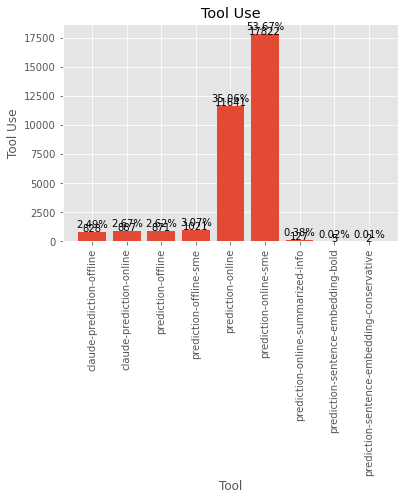

In [9]:
tool_use = dataset['tool'].groupby(dataset['tool']).count()

# plot tool use with data labels. use subplots plot % of tool use
fig, ax = plt.subplots()
ax.bar(tool_use.index, tool_use.values)
ax.set_xticklabels(tool_use.index, rotation=90)
ax.set_ylabel('Tool Use')
ax.set_xlabel('Tool')
ax.set_title('Tool Use')
for i, v in enumerate(tool_use.values):
    ax.text(i, v + 3, str(v), ha='center')
    # get percentage of tool use
    total = tool_use.values.sum()
    percent = v / total * 100
    ax.text(i, v + 350, f'{percent:.2f}%', ha='center')
plt.show()


From above, there is currently a strong tendency to choose the prediction-online and prediction-online-sme tools. This is despite the higher accuracy of the claude-based tools.


<AxesSubplot:title={'center':'p_yes for every tool'}, xlabel='tool', ylabel='p_yes'>

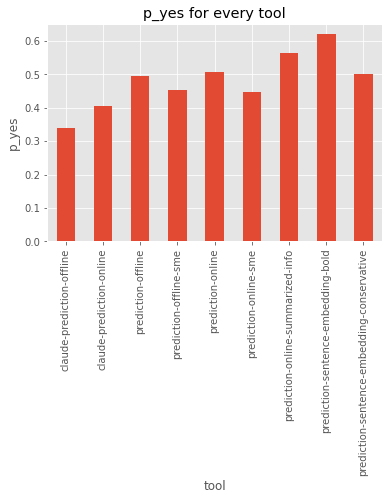

In [10]:
# plot p_yes for every tool
dataset.groupby('tool')['p_yes'].mean().plot(kind='bar', title='p_yes for every tool', ylabel='p_yes', xlabel='tool', rot=90)

<AxesSubplot:title={'center':'p_no for every tool'}, xlabel='tool', ylabel='p_no'>

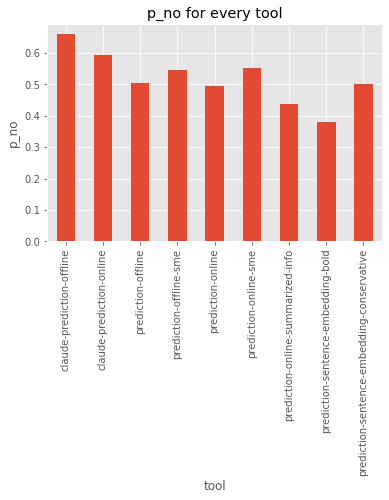

In [11]:
dataset.groupby('tool')['p_no'].mean().plot(kind='bar', title='p_no for every tool', ylabel='p_no', xlabel='tool', rot=90)

Text(0.5, 0, 'Tool')

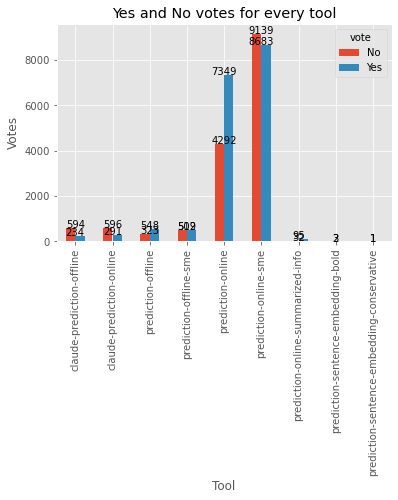

In [12]:
tool_vote = dataset.groupby(['tool', 'vote'])['vote'].count().unstack()

fig, ax = plt.subplots()
# plot Yes and No votes for every tool unstacked
ax = tool_vote.plot(kind='bar', stacked=False, ax=ax, rot=90, title='Yes and No votes for every tool')

# Data labels
for i, v in enumerate(tool_vote['Yes']):
    ax.text(i, v + 3, str(v), ha='center')

for i, v in enumerate(tool_vote['No']):
    ax.text(i, v + 3, str(v), ha='center')

ax.set_ylabel('Votes')
ax.set_xlabel('Tool')

From above, it seems like the prediction-online tool may have a large bias towards yes answers.

In [13]:
dataset['win'] = (dataset['currentAnswer'] == dataset['vote'])

tool_performance = dataset.groupby('tool').agg(
    total_bets=pd.NamedAgg(column='id', aggfunc='count'),
    wins=pd.NamedAgg(column='win', aggfunc='sum')
)
tool_performance['win_rate'] = tool_performance['wins'] / tool_performance['total_bets']
print(tool_performance)

                                            total_bets  wins  win_rate
tool                                                                  
claude-prediction-offline                          828   469      0.57
claude-prediction-online                           887   458      0.52
prediction-offline                                 871   389      0.45
prediction-offline-sme                            1021   532      0.52
prediction-online                                11641  5727      0.49
prediction-online-sme                            17822  9210      0.52
prediction-online-summarized-info                  127    61      0.48
prediction-sentence-embedding-bold                   5     3       0.6
prediction-sentence-embedding-conservative           2     2       1.0


The Claude-based tools are the most accurate. However, they are not chosen nearly as much as the main two. 

### Check the percentage of wins vs confidence for all the tools

In [14]:
tools_group = dataset.groupby("tool")
tools_stats_per_conf = gen_stats(df=dataset, tools_group=tools_group, group=tools_group, col="confidence")
display(tools_stats_per_conf)

confidence_0.2                  \
                                                n_correct n_pred accuracy   
tool                                                                        
claude-prediction-offline                             0.0    0.0      NaN   
claude-prediction-online                              0.0    1.0      0.0   
prediction-offline                                    0.0    0.0      NaN   
prediction-offline-sme                                0.0    0.0      NaN   
prediction-online                                     0.0    0.0      NaN   
prediction-online-sme                                 0.0    0.0      NaN   
prediction-online-summarized-info                     0.0    0.0      NaN   
prediction-sentence-embedding-bold                    0.0    0.0      NaN   
prediction-sentence-embedding-conservative            0.0    0.0      NaN   

                                           confidence_0.3                  \
                                                n_correct n_pred accuracy   
tool                                                                        
claude-prediction-offline                             0.0    0.0      NaN   
claude-prediction-online                              1.0    4.0     25.0   
prediction-offline                                    0.0    0.0      NaN   
prediction-offline-sme                                0.0    0.0      NaN   
prediction-online                                     0.0    0.0      NaN   
prediction-online-sme                                 0.0    0.0      NaN   
prediction-online-summarized-info                     0.0    0.0      NaN   
prediction-sentence-embedding-bold                    0.0    0.0      NaN   
prediction-sentence-embedding-conservative            0.0    0.0      NaN   

                                           confidence_0.35                  \
                                                 n_correct n_pred accuracy   
tool                                                                         
claude-prediction-offline                              0.0    0.0      NaN   
claude-prediction-online                               0.0    1.0      0.0   
prediction-offline                                     0.0    0.0      NaN   
prediction-offline-sme                                 0.0    0.0      NaN   
prediction-online                                      0.0    0.0      NaN   
prediction-online-sme                                  0.0    0.0      NaN   
prediction-online-summarized-info                      0.0    0.0      NaN   
prediction-sentence-embedding-bold                     0.0    0.0      NaN   
prediction-sentence-embedding-conservative             0.0    0.0      NaN   

                                           confidence_0.4                  \
                                                n_correct n_pred accuracy   
tool                                                                        
claude-prediction-offline                             0.0    1.0      0.0   
claude-prediction-online                              1.0    2.0     50.0   
prediction-offline                                    0.0    0.0      NaN   
prediction-offline-sme                                0.0    0.0      NaN   
prediction-online                                     0.0    0.0      NaN   
prediction-online-sme                                 0.0    0.0      NaN   
prediction-online-summarized-info                     0.0    0.0      NaN   
prediction-sentence-embedding-bold                    0.0    0.0      NaN   
prediction-sentence-embedding-conservative            0.0    0.0      NaN   

                                           confidence_0.5                  \
                                                n_correct n_pred accuracy   
tool                                                                        
claude-prediction-offline                           298.0  486.0    61.32   
claude-prediction-onlin

In [15]:
tool_performance = dataset.groupby('tool').agg(
    total_bets=pd.NamedAgg(column='id', aggfunc='count'),
    wins=pd.NamedAgg(column='win', aggfunc='sum')
)
tool_performance['win_rate'] = tool_performance['wins'] / tool_performance['total_bets']
print(tool_performance.sort_values(by='total_bets', ascending=False))


                                            total_bets  wins  win_rate
tool                                                                  
prediction-online-sme                            17822  9210      0.52
prediction-online                                11641  5727      0.49
prediction-offline-sme                            1021   532      0.52
claude-prediction-online                           887   458      0.52
prediction-offline                                 871   389      0.45
claude-prediction-offline                          828   469      0.57
prediction-online-summarized-info                  127    61      0.48
prediction-sentence-embedding-bold                   5     3       0.6
prediction-sentence-embedding-conservative           2     2       1.0


As before, the tools chosen most often are not necessarily the most accurate.

In [16]:
confidence_performance = dataset.groupby('confidence').agg(
    total_bets=pd.NamedAgg(column='id', aggfunc='count'),
    wins=pd.NamedAgg(column='win', aggfunc='sum')
)
confidence_performance['win_rate'] = confidence_performance['wins'] / confidence_performance['total_bets']
print(confidence_performance)


            total_bets   wins  win_rate
confidence                             
0.20                 1      0       0.0
0.30                 4      1      0.25
0.35                 1      0       0.0
0.40                 3      1      0.33
0.50               694    392      0.56
0.55                 2      1       0.5
0.60               864    443      0.51
0.62                 1      1       1.0
0.68                 1      1       1.0
0.70              6144   3299      0.54
0.80             22812  11204      0.49
0.81                 1      0       0.0
0.90              2640   1480      0.56
1.00                36     28      0.78


From above, there is no real discernible trend between confidence and accuracy. Sometimes, 50% confidence results in better win rate than 60-90% confidence. 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

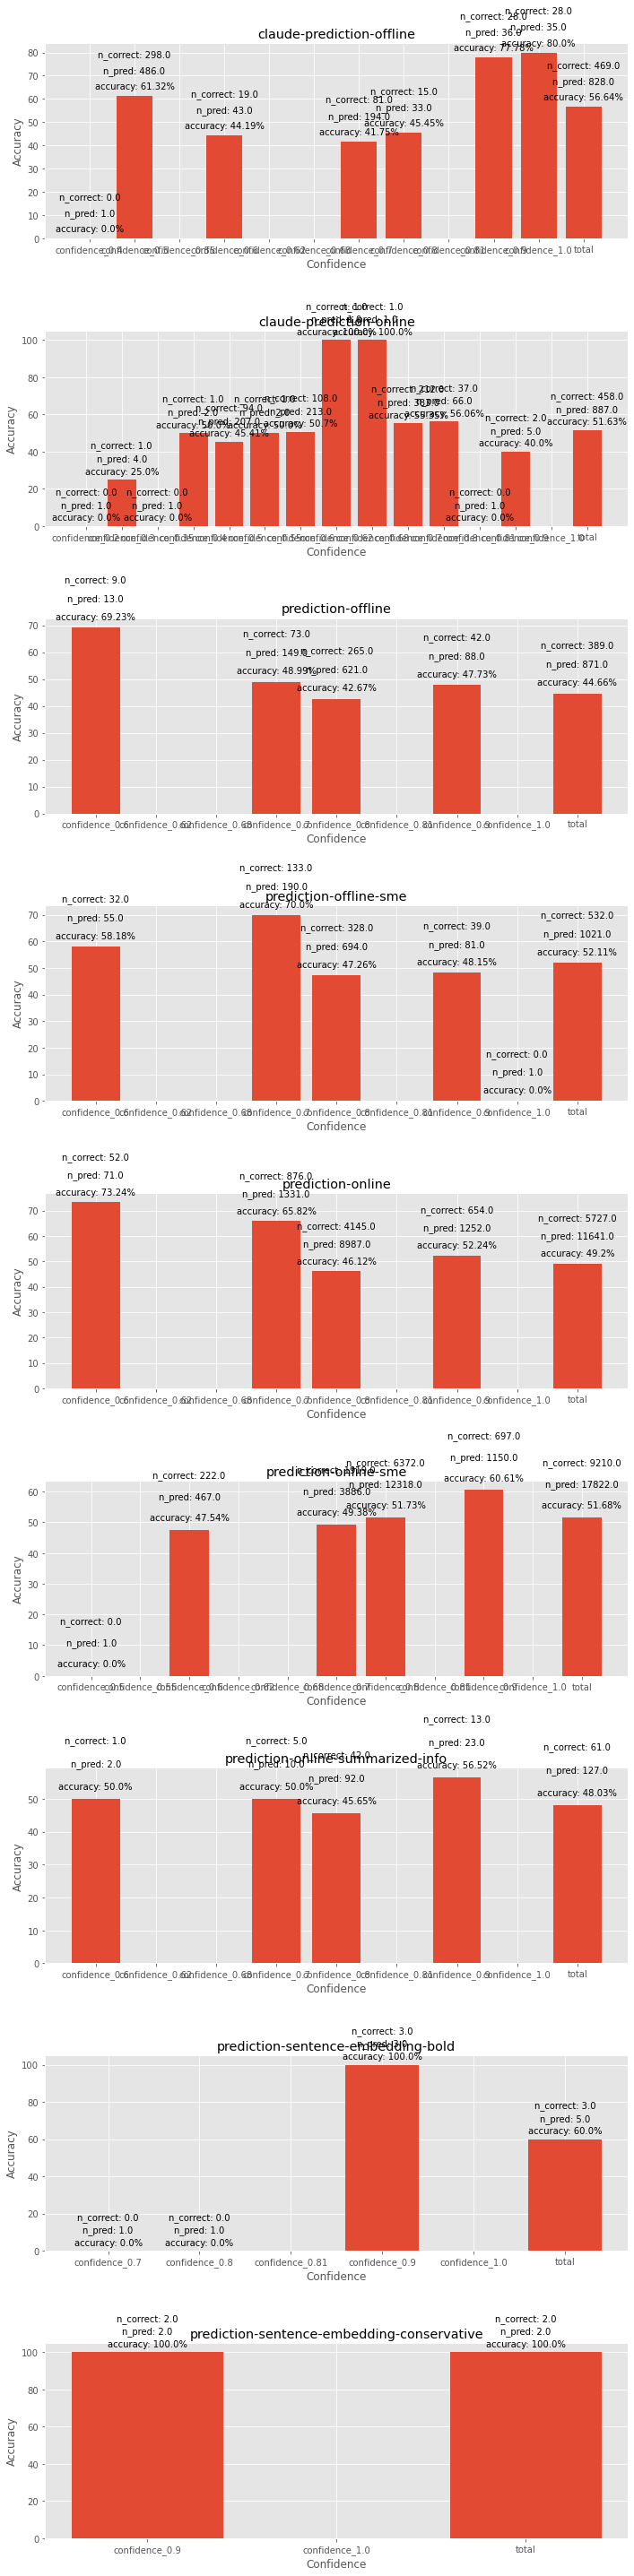

In [17]:
tools = tools_stats_per_conf.index

fig, axes = plt.subplots(nrows=len(tools), ncols=1, figsize=(10, 40))

for i, tool in enumerate(tools):
    ax = axes[i]
    tool_stats = tools_stats_per_conf.loc[tool].unstack(level=0).loc["accuracy"]
    ax.bar(tool_stats.index, tool_stats.values)
    ax.set_title(tool)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Confidence")

    for j, v in enumerate(tool_stats.values):

        # add n_pred and n_correct
        n_pred = tools_stats_per_conf.loc[tool].unstack(level=0).loc["n_pred"]
        n_correct = tools_stats_per_conf.loc[tool].unstack(level=0).loc["n_correct"]
        ax.text(j, v + 10, f"n_pred: {n_pred[j]}", ha='center')
        ax.text(j, v + 17, f"n_correct: {n_correct[j]}", ha='center')
        ax.text(j, v + 3, f"accuracy: {round(v, 2)}%", ha='center')

plt.tight_layout()

The above shows that for each tool, higher confidences do not really bring higher accuracy. 

In [18]:
vote_analysis = dataset['vote'].value_counts()
print(vote_analysis)

Yes    17723
No     15481
Name: vote, dtype: Int64


In [19]:
correlation_matrix = dataset[['confidence', 'info_utility', 'win_probability', 'win',]].corr()
print(correlation_matrix)

                 confidence  info_utility  win_probability       win
confidence             1.00      3.60e-01            -0.25 -1.16e-02
info_utility           0.36      1.00e+00            -0.14 -9.04e-03
win_probability       -0.25     -1.38e-01             1.00  7.80e-02
win                   -0.01     -9.04e-03             0.08  1.00e+00


In [20]:
# value counts above 50
sel = list(dataset['id'].value_counts()[dataset['id'].value_counts() > 30].index)
sel_dataset = dataset[dataset['id'].isin(sel)]
sel_dataset['id'].nunique()

402

Text(0.5, 1.0, 'Number of Tools per ID. Total IDs: 402')

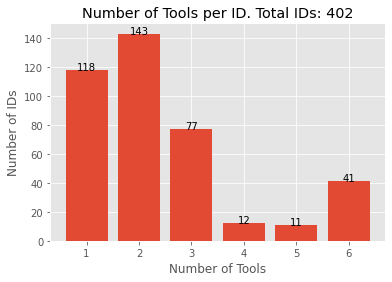

In [21]:
tools_per_id = sel_dataset.groupby('id')['tool'].nunique()

tools_per_id = tools_per_id.value_counts().sort_index()


fig, ax = plt.subplots()
ax.bar(tools_per_id.index, tools_per_id.values)
ax.set_ylabel('Number of IDs')
ax.set_xlabel('Number of Tools')

for i, v in enumerate(tools_per_id.values):
    ax.text(i+1, v, str(v), ha='center')

plt.title('Number of Tools per ID. Total IDs: ' + str(sel_dataset['id'].nunique()))

The above chart shows for each id/title what is the diversity of the tools used. Mostly, 1 or 2 is used.


In [22]:
dataset[['id', 'currentAnswer']].drop_duplicates()['currentAnswer'].value_counts()

No     858
Yes    478
no       1
Name: currentAnswer, dtype: Int64

In [23]:
vote_counts_per_id = dataset.groupby('id')['vote'].value_counts().unstack(fill_value=0)
vote_counts_per_id['yes_no_ratio'] = vote_counts_per_id['Yes'] / (vote_counts_per_id['No'] +1)

In [24]:
vote_counts_per_id['yes_perc'] = vote_counts_per_id['Yes']/(vote_counts_per_id['Yes'] + vote_counts_per_id['No'])
vote_counts_per_id['no_perc'] = vote_counts_per_id['No']/(vote_counts_per_id['Yes'] + vote_counts_per_id['No'])

In [25]:
vote_counts_per_id['yes_perc'].min(), vote_counts_per_id['yes_perc'].max(), vote_counts_per_id['yes_perc'].mean(), vote_counts_per_id['yes_perc'].median()

(0.0, 1.0, 0.5932743877482011, 0.6666666666666666)

In [26]:
vote_counts_per_id['no_perc'].min(), vote_counts_per_id['no_perc'].max(), vote_counts_per_id['no_perc'].mean(), vote_counts_per_id['no_perc'].median()

(0.0, 1.0, 0.40672561225179904, 0.3333333333333333)

<AxesSubplot:title={'center':'Number of prompts per ID'}, xlabel='Number of prompts', ylabel='Number of IDs'>

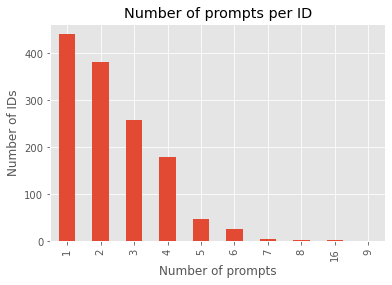

In [27]:
dataset.groupby('id')['prompt'].nunique().value_counts().plot(kind='bar', title='Number of prompts per ID', ylabel='Number of IDs', xlabel='Number of prompts')

The above chart shows for each id/title what is the diversity of the prompt coming from the trader. It seems that the default prompt is rarely changed.